In [49]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs

def plot_dataset(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y)


def plot_hyperplane(vector, intercept=0, dataset=None):
    xs = np.array([0, 1])
    ys = -(vector[0] * xs + intercept) / vector[1]
    plt.plot(xs, ys, 'r-')

def sign(a):
    return (a >= 0) * 2 - 1

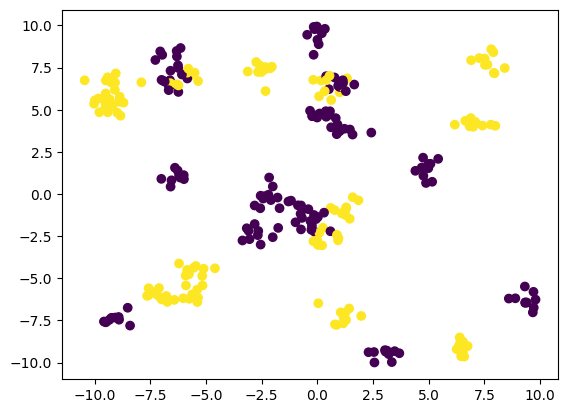

In [50]:
def create_hard_dataset(n=300, centers=30, std=0.4):
  X, y = make_blobs(n_samples=n, centers=centers, cluster_std=std)
  y = sign(np.array(y%2, dtype=int)*2-1)
  return X, y

X, y = create_hard_dataset()

plot_dataset(X, y)
plt.show()

In [51]:
from scipy.special import expit

include_bias = lambda X: np.c_[np.ones(X.shape[0]), X]  # Add bias column to input matrix

def tanh(a):
    return expit(a) * 2 - 1  # Convert sigmoid output to tanh range

def get_axes_limits(X):
    offset = 0.5
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1 - offset, max1 + offset, min2 - offset, max2 + offset]

def plot_predictions(clf, X):
    axes = get_axes_limits(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X_grid = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X_grid).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

In [77]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

def sigmoid(x):
    return expit(x)

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def tanh_derivative(x):
    return 1 - np.square(tanh(x))

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

ACTIVATION_FUNCTIONS = {
    'tanh': (tanh, tanh_derivative),
    'sigmoid': (sigmoid, sigmoid_derivative),
    'relu': (relu, relu_derivative)
}

class MultiLayer(BaseEstimator, ClassifierMixin):
    def __init__(self, max_iter=1000, learning_rate=0.01, n_hidden=[2], activations=None):
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.n_hidden = n_hidden
        if activations is None:
            self.activations = ['tanh'] * len(n_hidden)
        else:
            self.activations = activations
        
        for act in self.activations:
            if act not in ACTIVATION_FUNCTIONS:
                raise ValueError(f"Unsupported activation function: {act}")

    def forward(self, X):
        self.A = []
        self.Z = []
        AUX = X.copy()
        
        for i, W in enumerate(self.Ws):
            self.A.append(include_bias(AUX))
            self.Z.append(self.A[-1] @ W)
            
            if i < len(self.activations):
                activation_func, _ = ACTIVATION_FUNCTIONS[self.activations[i]]
                AUX = activation_func(self.Z[-1])
            else:
                # For output layer, use tanh by default
                AUX = tanh(self.Z[-1])
        
        return AUX

    def backward(self, Xb, y, ypred):
        grads = []
        output_delta = y - ypred
        grads.insert(0, self.A[-1].T @ output_delta)
        
        for i in range(len(self.Ws)-1, 0, -1):
            if i-1 < len(self.activations):
                _, derivative_func = ACTIVATION_FUNCTIONS[self.activations[i-1]]
                activation_grad = derivative_func(self.Z[i-1])
            else:
                activation_grad = tanh_derivative(self.Z[i-1])
            
            input_delta = (output_delta @ self.Ws[i][1:, :].T) * activation_grad
            grads.insert(0, self.A[i-1].T @ input_delta)
            output_delta = input_delta.copy()
        
        for i in range(len(self.Ws)-1, -1, -1):
            self.Ws[i] += grads[i] * self.learning_rate

    def fit(self, X, y):
        self.Ws = []
        previous_output = X.shape[1]
        for layer_size in self.n_hidden:
            self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, layer_size)))
            previous_output = layer_size
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)
        self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, y.shape[1])))
        
        for _ in range(self.max_iter):
            ypred = self.forward(X)
            self.backward(X, y, ypred)
        return self

    def predict(self, X):
        ypred = self.forward(X)
        return sign(ypred)

0.9


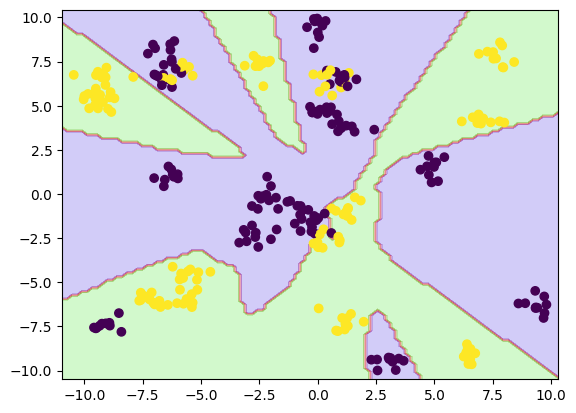

In [85]:
model = MultiLayer(n_hidden=[32,16], activations=['tanh', 'sigmoid'])
model.fit(X, y)
print(accuracy_score(y, model.predict(X)))
plot_predictions(model, X)
plot_dataset(X, y)
plt.show()

0.96


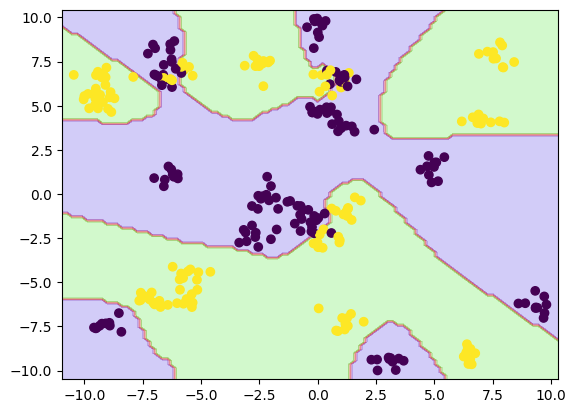

In [88]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='tanh',
    solver='adam',
    max_iter=1000,
    learning_rate_init=0.01,
    # random_state=42,
    batch_size=len(X) 
)

mlp.fit(X, y)

print(accuracy_score(y, mlp.predict(X)))
plot_predictions(mlp, X)
plot_dataset(X, y)
plt.show()

## Neural Network Performance Comparison

A benchmark comparing a custom **MultiLayer** neural network implementation against scikit-learn's **MLPClassifier** across multiple datasets.

### 1. Benchmarking Setup
- Tests both models on **200 randomly generated datasets** using `create_hard_dataset()`
- Each dataset contains **300 samples** with **30 cluster centers** and **0.4 standard deviation**
- Both models use identical architectures: **2 hidden layers** with **32 and 16 neurons**

### 2. Model Configurations
- **Custom MultiLayer**: Uses mixed activations (tanh + sigmoid) with basic gradient descent
- **MLPClassifier**: Uses tanh activation with Adam optimizer

### 3. Performance Metrics
- **Accuracy**: Classification performance on each dataset
- **Training Time**: Time required to fit each model

### Purpose
This benchmark evaluates whether the custom neural network implementation can compete with scikit-learn's optimized version, revealing trade-offs between **simplicity** and **performance** in terms of both accuracy and computational efficiency.


=== SUMMARY STATISTICS ===
Average Accuracy - MultiLayer: 0.8766 ± 0.0568
Average Accuracy - MLPClassifier: 0.9533 ± 0.0292

Average Training Time - MultiLayer: 0.232s ± 0.017s
Average Training Time - MLPClassifier: 0.067s ± 0.022s

Accuracy wins:
MultiLayer won on 3 datasets (1.5%)
MLPClassifier won on 196 datasets (98.0%)

Training time wins:
MultiLayer won on 0 datasets (0.0%)
MLPClassifier won on 200 datasets (100.0%)


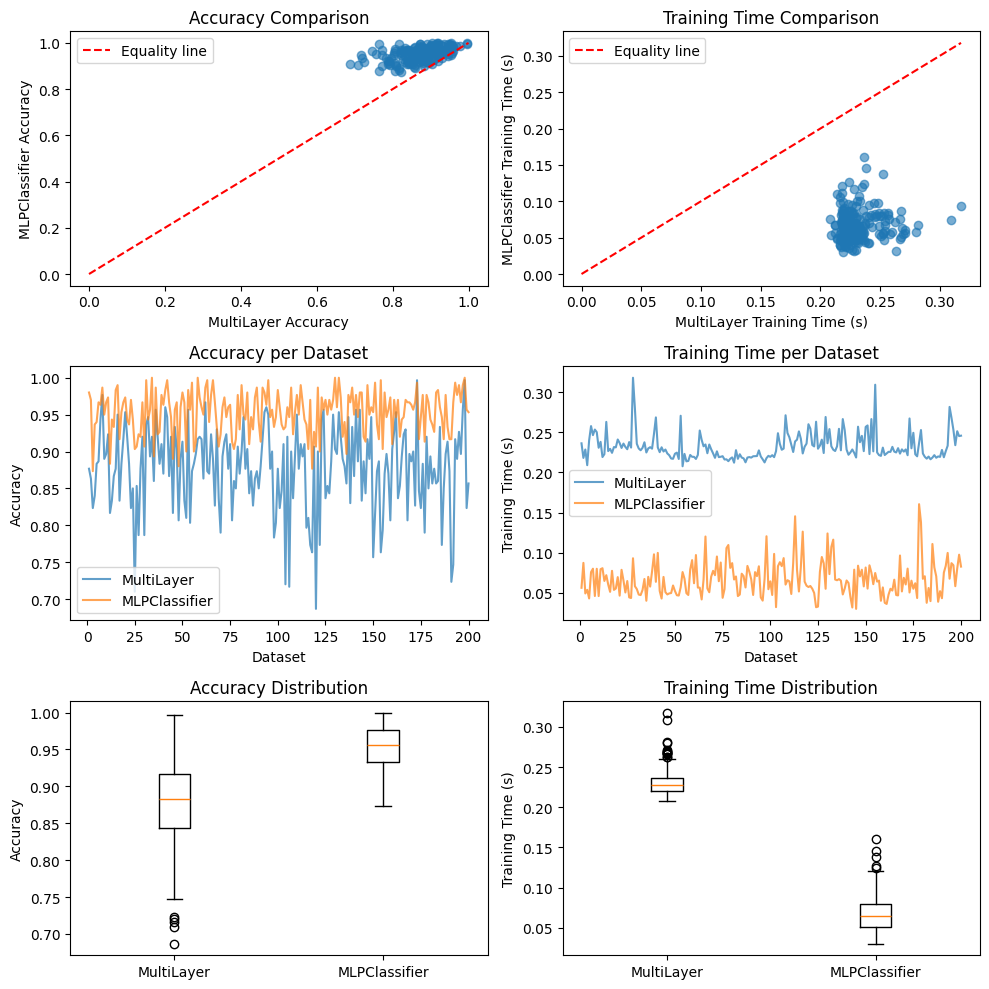

In [131]:
import time
import pandas as pd

n_datasets = 200

def compare_models_multiple_datasets():
    results = []
    
    for i in range(n_datasets):
        X_i, y_i = create_hard_dataset()
        
        start_time = time.time()
        custom_model = MultiLayer(n_hidden=[32, 16], activations=['tanh', 'sigmoid'])
        custom_model.fit(X_i, y_i)
        custom_time = time.time() - start_time
        custom_accuracy = accuracy_score(y_i, custom_model.predict(X_i))
        
        start_time = time.time()
        sklearn_model = MLPClassifier(
            hidden_layer_sizes=(32, 16),
            activation='tanh',
            solver='adam',
            max_iter=1000,
            learning_rate_init=0.01,
            random_state=42
        )
        sklearn_model.fit(X_i, y_i)
        sklearn_time = time.time() - start_time
        sklearn_accuracy = accuracy_score(y_i, sklearn_model.predict(X_i))
        
        results.append({
            'dataset': i + 1,
            'custom_accuracy': custom_accuracy,
            'sklearn_accuracy': sklearn_accuracy,
            'custom_time': custom_time,
            'sklearn_time': sklearn_time,
            'accuracy_diff': custom_accuracy - sklearn_accuracy,
            'time_diff': custom_time - sklearn_time
        })
    
    return pd.DataFrame(results)

results_df = compare_models_multiple_datasets()

print("\n=== SUMMARY STATISTICS ===")
print(f"Average Accuracy - MultiLayer: {results_df['custom_accuracy'].mean():.4f} ± {results_df['custom_accuracy'].std():.4f}")
print(f"Average Accuracy - MLPClassifier: {results_df['sklearn_accuracy'].mean():.4f} ± {results_df['sklearn_accuracy'].std():.4f}")
print(f"\nAverage Training Time - MultiLayer: {results_df['custom_time'].mean():.3f}s ± {results_df['custom_time'].std():.3f}s")
print(f"Average Training Time - MLPClassifier: {results_df['sklearn_time'].mean():.3f}s ± {results_df['sklearn_time'].std():.3f}s")

print("\nAccuracy wins:")
print(f"MultiLayer won on {(results_df['accuracy_diff'] > 0).sum()} datasets ({(results_df['accuracy_diff'] > 0).sum()/n_datasets*100:.1f}%)")
print(f"MLPClassifier won on {(results_df['accuracy_diff'] < 0).sum()} datasets ({(results_df['accuracy_diff'] < 0).sum()/n_datasets*100:.1f}%)")

print("\nTraining time wins:")
print(f"MultiLayer won on {(results_df['time_diff'] < 0).sum()} datasets ({(results_df['time_diff'] < 0).sum()/n_datasets*100:.1f}%)")
print(f"MLPClassifier won on {(results_df['time_diff'] > 0).sum()} datasets ({(results_df['time_diff'] > 0).sum()/n_datasets*100:.1f}%)")

plt.figure(figsize=(10, 10))

# Accuracy comparison
plt.subplot(3, 2, 1)
plt.scatter(results_df['custom_accuracy'], results_df['sklearn_accuracy'], alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--', label='Equality line')
plt.xlabel('MultiLayer Accuracy')
plt.ylabel('MLPClassifier Accuracy')
plt.title('Accuracy Comparison')
plt.legend()

# Time comparison
plt.subplot(3, 2, 2)
plt.scatter(results_df['custom_time'], results_df['sklearn_time'], alpha=0.6)
plt.plot([0, results_df[['custom_time', 'sklearn_time']].values.max()], 
         [0, results_df[['custom_time', 'sklearn_time']].values.max()], 'r--', label='Equality line')
plt.xlabel('MultiLayer Training Time (s)')
plt.ylabel('MLPClassifier Training Time (s)')
plt.title('Training Time Comparison')
plt.legend()

# Accuracy over datasets
plt.subplot(3, 2, 3)
plt.plot(results_df['dataset'], results_df['custom_accuracy'], alpha=0.7, label='MultiLayer')
plt.plot(results_df['dataset'], results_df['sklearn_accuracy'], alpha=0.7, label='MLPClassifier')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Accuracy per Dataset')
plt.legend()

# Time over datasets
plt.subplot(3, 2, 4)
plt.plot(results_df['dataset'], results_df['custom_time'], alpha=0.7, label='MultiLayer')
plt.plot(results_df['dataset'], results_df['sklearn_time'], alpha=0.7, label='MLPClassifier')
plt.xlabel('Dataset')
plt.ylabel('Training Time (s)')
plt.title('Training Time per Dataset')
plt.legend()

# Accuracy box plot
plt.subplot(3, 2, 5)
plt.boxplot([results_df['custom_accuracy'], results_df['sklearn_accuracy']], 
            tick_labels=['MultiLayer', 'MLPClassifier'])
plt.ylabel('Accuracy')
plt.title('Accuracy Distribution')

# Time box plot
plt.subplot(3, 2, 6)
plt.boxplot([results_df['custom_time'], results_df['sklearn_time']], 
            tick_labels=['MultiLayer', 'MLPClassifier'])
plt.ylabel('Training Time (s)')
plt.title('Training Time Distribution')

plt.tight_layout()
plt.show()